<a href="https://colab.research.google.com/github/iocariz/stock_market_analytics/blob/main/Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3


In [1]:
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

## Question 1 (1 point): Dummies on Month and Week-of-Month

Find the ABSOLUTE CORRELATION VALUE of the most correlated dummy <month-week_of_month> with the binary outcome variable is_positive_growth_5d_future?

You saw in the correlation analysis and modeling that September and October may be important seasonal months. In this task, we'll go futher and try to generate dummies for Month and Week-of-month (starting from 1). For example, the first week of October should be coded similar to this: 'October_w1'. Once you've generated the new set of variables, find the most correlated (in absolute value) one with is_positive_growth_5d_future and round it to 3 digits after the comma.

NOTE: new dummies will be used as features in the next tasks, please leave them in the dataset.

In [2]:
import os
os.getcwd()

'/content'

In [3]:
!gdown https://drive.google.com/file/d/1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP/view?usp=sharing --fuzzy -O /content/

Downloading...
From (original): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP
From (redirected): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP&confirm=t&uuid=d5305108-3b57-43d3-b11b-47e28b859d07
To: /content/stocks_df_combined_2024_05_07.parquet.brotli
100% 119M/119M [00:01<00:00, 72.5MB/s]


In [10]:
df_full = pd.read_parquet("/content/stocks_df_combined_2024_05_07.parquet.brotli", )
df = df_full[df_full.Date>='2000-01-01'].copy()

In [11]:
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
df['ln_volume'] = df.Volume.apply(lambda x: np.log(x))

 # manually defined features
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']
TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [12]:
df.loc[:,'Month'] = df.Month.dt.strftime('%B')
df.loc[:,'Weekday'] = df.Weekday.astype(str)

In [13]:
df['month_wom'] = df.apply(lambda row: f'{row["Month"]}-{(row["Date"].day-1)//7+1}', axis=1)

CATEGORICAL.append('month_wom')

In [14]:
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

DUMMIES = dummy_variables.columns
df_with_dummies = pd.concat([df, dummy_variables], axis=1)
df_with_corr = df_with_dummies[DUMMIES].corrwith(df['is_positive_growth_5d_future'])
df_with_corr.apply(np.abs).sort_values(ascending=False)

print(f'The highest value is {df_with_corr.apply(np.abs).sort_values(ascending=False).iloc[0]} for {df_with_corr.apply(np.abs).sort_values(ascending=False).index[0]}')

The highest value is 0.03453687650579432 for month_wom_September-3


## Question 2 (2 points): Define new "hand" rules on macro and technical indicators variables
What is the precision score for the best of the NEW predictions (pred3 or pred4), rounded to 3 digits after the comma?

Let's utilize the knowledge from the visualised tree (clf10) (Code Snippet 5: 1.4.4 Visualisation):

You're asked to define two new 'hand' rules (leading to 'positive' subtrees):

pred3_manual_gdp_fastd: (gdppot_us_yoy <= 0.027) & (fastd >= 0.251) pred4_manual_gdp_wti_oil: (gdppot_us_yoy >= 0.027) & (growth_wti_oil_30d <= 1.005) Extend the Code Snippet 3 (Manual "hand rule" predictions): Calculate and add new rules (pred3 and pred4) to the dataframe.You should notice that one of the predictions doesn't have any positive predictions on TEST dataset (while it has many on TRAIN+VALIDATION).

Debug: check in the new_df and the original dataset/data generation process that we didn't make any mistakes during the data transformation step.

Explain why this can happen even if there are no errors in the data features.

As a result, write down the precision score for the remaining predictor (round to three decimal points). E.g. if you have 0.57897, your answer should be 0.579.

In [15]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [16]:
new_df = df_with_dummies.copy()
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_1d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_1d'] > 1) & (new_df['growth_snp500_1d'] > 1)).astype(int)
new_df['pred3_manual_gdp_fastd'] = ((new_df['gdppot_us_yoy'] <= 0.027) & (new_df['fastd'] >= 0.251)).astype(int)
new_df['pred4_manual_gdp_wti_oil']=((new_df['gdppot_us_yoy']>=0.027) & (new_df['growth_wti_oil_30d'] <= 1.005)).astype(int)
rule_thumb_prediction = new_df[new_df["split"] == 'test'][['pred4_manual_gdp_wti_oil', 'pred3_manual_gdp_fastd', 'is_positive_growth_5d_future']]

print(f'Accuracy {round((rule_thumb_prediction["pred3_manual_gdp_fastd"]==rule_thumb_prediction["is_positive_growth_5d_future"]).sum()/len(rule_thumb_prediction),3)}')

Accuracy 0.555


**Question 3 (1 point): Unique correct predictions from a 10-levels deep Decision Tree Classifier (pred5_clf_10)**
What is the total number of records in the TEST dataset when the new prediction pred5_clf_10 is better than all 'hand' rules (pred0..pred4)?
NOTE: please include random_state=42 to Decision Tree Classifier init function (line clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)) to ensure everyone gets the same results.

Suggested solution:

Step1: Rewrite the '1.4.3 Inference for a decision tree' piece for the Decision Tree Classifier with max_depth=10 (clf_10), so that you fit the model on TRAIN+VALIDATION sets (unchanged from the lecture), but predict on the whole set X_all (to be able to define a new column 'pred5_clf_10' in the dataframe new_df). Here is the link with explanation. It will solve the problem in 1.4.5 when predictions were made only for Test dataset and couldn't be easily joined with the full dataset.

Step2: Once you have it, define a new column 'only_pred5_is_correct' similar to 'hand' prediction rules with several conditions: is_positive_growth_5d_future AND is_correct_pred5 should be equal 1, while all other predictions is_correct_pred0..is_correct_pred4 should be equal to 0.

Step3: Convert 'only_pred5_is_correct' column from bool to int, and find how many times it is equal to 1 in the TEST set. Write down this as an answer.

ADVANCED: define a function that can be applied to the whole row of predictions (a few examples of pandas-apply-row-functions) and can find whether some prediction 'predX' (where X is one of the predictions) is uniquely correct. It should work even if there are 100 predictions available, so that you don't define manually the condition for 'predX'.

In [41]:
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [42]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score

def remove_infinite_values(X):
    """
    Remove infinite values from the input array.

    Parameters:
    - X: Input array (NumPy array or array-like)

    Returns:
    - Array with infinite values removed
    """
    return X[np.isfinite(X).all(axis=1)]

# Example usage:
# Assuming X is your input data

In [43]:
# Split the data into training and testing sets based on the split date
features_list = NUMERICAL+DUMMIES.to_list()
to_predict = 'is_positive_growth_5d_future'

train_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df = new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
# need Date and Ticker later when merging predictions to the dataset
X_train = train_df[features_list+[to_predict,'Date','Ticker']]
X_test = test_df[features_list+[to_predict,'Date','Ticker']]

print(f'length: X_train {X_train.shape},  X_test {X_test.shape}')

length: X_train (152846, 302),  X_test (29829, 302)


In [44]:
# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Need to fill NaNs somehow
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

print(f'length: X_train_imputed {X_train.shape}, X_test_imputed {X_test.shape}')

length: X_train_imputed (152846, 302), X_test_imputed (29829, 302)


In [45]:
y_train = X_train[to_predict]
y_test = X_test[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train[to_predict]
del X_test[to_predict]

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [47]:
clf_10, train_columns = fit_decision_tree(X=X_train.drop(['Date','Ticker'],axis=1),
                           y=y_train,
                           max_depth=10)

In [49]:
X_train.isna().sum()

growth_1d                0
growth_3d                0
growth_7d                0
growth_30d               0
growth_90d               0
                        ..
month_wom_September-3    0
month_wom_September-4    0
month_wom_September-5    0
Date                     0
Ticker                   0
Length: 301, dtype: int64

In [51]:
new_df.fillna(0, inplace=True)

In [52]:
new_df['pred5_clf10'] = clf_10.predict(new_df[features_list].replace([np.inf, -np.inf], 0))

pred_columns = [_pred  for _pred in new_df.columns if 'pred' in _pred]
pred_columns.remove( 'pred5_clf10')
pred_columns

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_fastd',
 'pred4_manual_gdp_wti_oil']

In [53]:
def only_tree_is_correct(row):
    if (row['pred5_clf10']!=1) and (row['is_positive_growth_5d_future']!=1):
        return False
    for _pred_col in pred_columns:
        if row[_pred_col]==1:
            return False

    return True

new_df[new_df.split == 'test'].apply(only_tree_is_correct, axis=1).sum()

4

# Question 4: (2 points) Hyperparameter tuning for a Decision Tree
## What is the optimal tree depth (from 1 to 20) for a DecisionTreeClassifier?

NOTE: please include random_state=42 to Decision Tree Classifier init function (line clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)) to ensure consistency in results.

Follow these steps to find the optimal max_depth:

Iterate through max_depth values from 1 to 20. Train the Decision Tree Classifier with the current max_depth parameter. Optionally, visualize how the 'head' of each fitted tree changes with more advanced (=deep) trees. You can use the sklearn.tree.plot_tree() function, or the compact way with the export_text() functionality (Stack Overflow example):

from sklearn.tree import export_text
tree_rules = export_text(model, feature_names=list(X_train), max_depth=3)
print(tree_rules)
Calculate the precision score (you can use the function sklearn.metrics.precision_score()) on the TEST dataset for each of the fitted trees. You can also compare it with the precision score on a VALIDATION dataset, which is included to the training phase (to have more data to train on). You should see that the precision score on a VALIDATION set starts to grow with the complexity of a tree (overfit), which isn't seen on the precision score on TEST. Identify the optimal max_depth, where the precision score is the highest on the TEST dataset. Record this value as best_max_depth and submit as an answer. Make predictions on all records (TRAIN+VALIDATION+TEST) and add the new prediction pred6_clf_best to the dataframe new_df. Additionally, compare the precision score of the tuned decision tree with previous predictions. You should observe an improvement (>0.58, or more than 58% precision), indicating that the tuned tree outperforms previous manual "hand" rules and Decision Tree predictions.

In [54]:
from collections import defaultdict
trees_result = defaultdict(int)


for k in range(6,7):
    print(f'Training tree with depth {k}')
    clf, train_columns = fit_decision_tree(X=X_train.drop(['Date','Ticker'],axis=1),
                           y=y_train,
                           max_depth=k)
    print(f'Accuracy on test: {precision_score(y_test, clf.predict(X_test.drop(columns=["Date", "Ticker"])))}')

    trees_result[k] = precision_score(y_test, clf.predict(X_test.drop(columns=["Date", "Ticker"])))

    y_val = new_df[new_df.split == 'validation'][to_predict]
    X_val = new_df[new_df.split == 'validation'][features_list].replace([np.inf, -np.inf], 0)
    print(f'Accuracy on validation: {precision_score(y_val, clf.predict(X_val))}')


Training tree with depth 6
Accuracy on test: 0.5711735485873952
Accuracy on validation: 0.5703184100130665


In [55]:
# Retraining with all futures

X = new_df.copy(deep=True)

X = X[features_list+[to_predict,'Date','Ticker']]
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)
y = X[to_predict]
del X[to_predict]

print(f'Training tree with depth {6}')
clf, train_columns = fit_decision_tree(X=X.drop(['Date','Ticker'],axis=1),
                        y=y,
                        max_depth=6)


new_df['pred6_clf'] = clf.predict(new_df[features_list].replace([np.inf, -np.inf], 0))

pred_columns = [_pred  for _pred in new_df.columns if 'pred' in _pred]
pred_columns.remove( 'pred6_clf')
pred_columns

Training tree with depth 6


['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_fastd',
 'pred4_manual_gdp_wti_oil',
 'pred5_clf10']

In [56]:
!pip install tqdm

In [66]:
from tqdm.notebook import tqdm

DEPTHS = range(1,21)
PRECISION = {}

for depth in tqdm(DEPTHS):
  clf, _ = fit_decision_tree(X_train.drop(['Date','Ticker'],axis=1), y_train, max_depth=depth)
  y_pred = clf.predict(X_test.drop(['Date','Ticker'],axis=1))
  precision = precision_score(y_test, y_pred)
  PRECISION[f'max_depths_{depth}'] = precision

  0%|          | 0/20 [00:00<?, ?it/s]

In [67]:
sorted_PRECISION = {k: round(v, 3) for k, v in sorted(PRECISION.items(), key=lambda item: item[1], reverse=True)}
sorted_PRECISION

{'max_depths_15': 0.586,
 'max_depths_14': 0.584,
 'max_depths_17': 0.577,
 'max_depths_20': 0.573,
 'max_depths_16': 0.572,
 'max_depths_12': 0.572,
 'max_depths_6': 0.571,
 'max_depths_13': 0.571,
 'max_depths_9': 0.57,
 'max_depths_7': 0.568,
 'max_depths_8': 0.568,
 'max_depths_18': 0.568,
 'max_depths_11': 0.567,
 'max_depths_10': 0.565,
 'max_depths_19': 0.564,
 'max_depths_5': 0.555,
 'max_depths_2': 0.555,
 'max_depths_4': 0.555,
 'max_depths_1': 0.555,
 'max_depths_3': 0.555}

In [72]:

# import matplot
import matplotlib.pyplot as plt

In [76]:
clf_15, _ = fit_decision_tree(X=X_train.drop(['Date','Ticker'],axis=1),
                           y=y_train,
                           max_depth=15)


In [78]:
feature_importances = pd.DataFrame(clf_15.feature_importances_,
                                   index = X_train.drop(['Date','Ticker'],axis=1).columns,
                                   columns=['importance']).sort_values('importance', ascending=False)


<Figure size 1000x800 with 0 Axes>

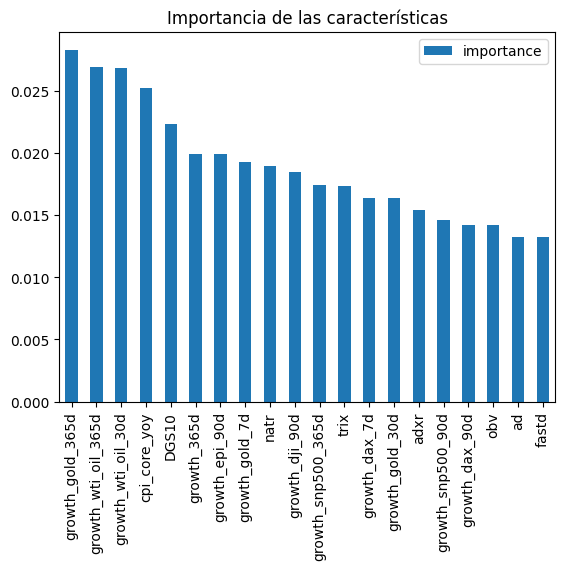

In [79]:

plt.figure(figsize=(10, 8))
feature_importances.head(20).plot(kind='bar')
plt.title("Importancia de las características")
plt.show()